In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import schwinger,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve

In [2]:
N=2
g=1
a=8
theta=np.pi
m=5
H,sx,sy,sz=schwinger(N=N,g=g,a=a,theta=theta,m=m)

In [3]:
H=H/20

In [4]:
Q=sx[-1]+1.1*sy[-1]+0.9*sz[-1] ## take a look at the berlin guys paper to see if this is a bad coupling operator

In [5]:
E01=1#H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
w0=0.5*a
gamma=w0/2
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)
lam

True


1.9679896712654306

In [6]:
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)
rho0=psi0*psi0.dag()
times=np.linspace(0,500,1000)
tfit=np.linspace(0, 50, 5000)

In [7]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

/home/gerardo/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/gerardo/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-9.04e-02 |-3.51e+00 |4.15e-20                              | 1         |-5.00e-01 |-1.00e+00 |3.87e+00                              
 2         | 5.15e-01 |-1.02e+00 |3.86e+00                              |                                                                        
                                                                        |A  normalized RM

In [8]:
times2 = np.linspace(0,50,100)
cvis = bath.correlation_function(times2)

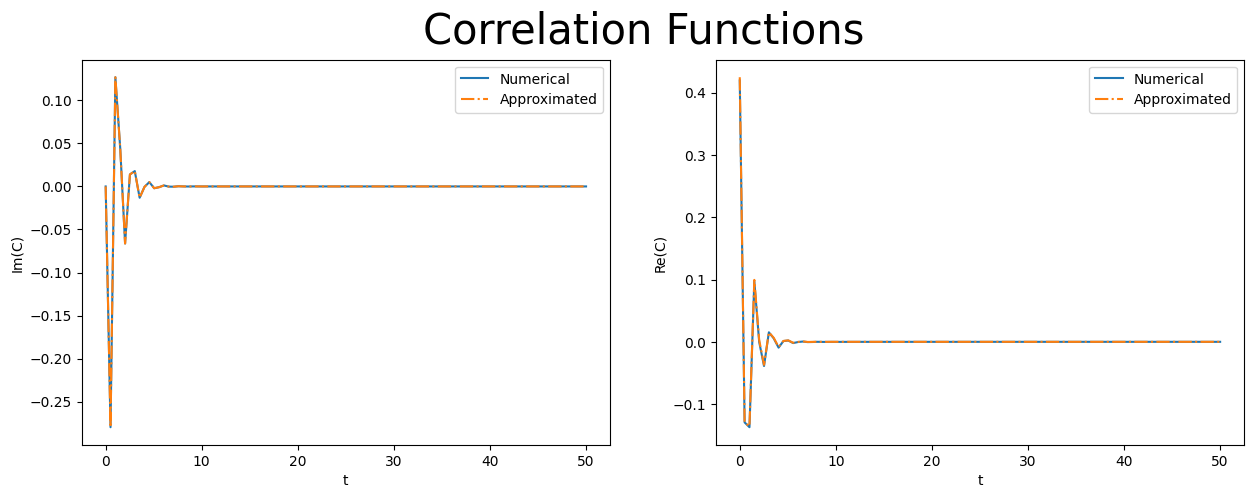

In [9]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [10]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   7.56s. Est. time left: 00:00:01:07
20.0%. Run time:  15.10s. Est. time left: 00:00:01:00
30.0%. Run time:  22.65s. Est. time left: 00:00:00:52
40.0%. Run time:  30.20s. Est. time left: 00:00:00:45
50.1%. Run time:  37.74s. Est. time left: 00:00:00:37
60.1%. Run time:  45.30s. Est. time left: 00:00:00:30
70.1%. Run time:  52.85s. Est. time left: 00:00:00:22
80.1%. Run time:  60.40s. Est. time left: 00:00:00:15
90.1%. Run time:  67.95s. Est. time left: 00:00:00:07
100.0%. Run time:  75.43s. Est. time left: 00:00:00:00
Total run time:  75.43s


In [11]:
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Calculating Integrals ...: 100%|█████████████| 25/25 [00:21<00:00,  1.16it/s]
Calculating time independent matrices...: 100%|█| 25/25 [00:00<00:00, 2742.38
Calculating time dependent generators: 100%|█| 25/25 [00:00<00:00, 137.03it/s
Computing Exponential of Generators . . . .: 100%|█| 1000/1000 [00:00<00:00, 


In [12]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-16}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-16})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-2.03e-02 |-1.12e+00 |1.25e-14                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.71e-02 |-5.34e+00 |6.54e-11                              |                                                                        
                                                                        |A  normalized RM

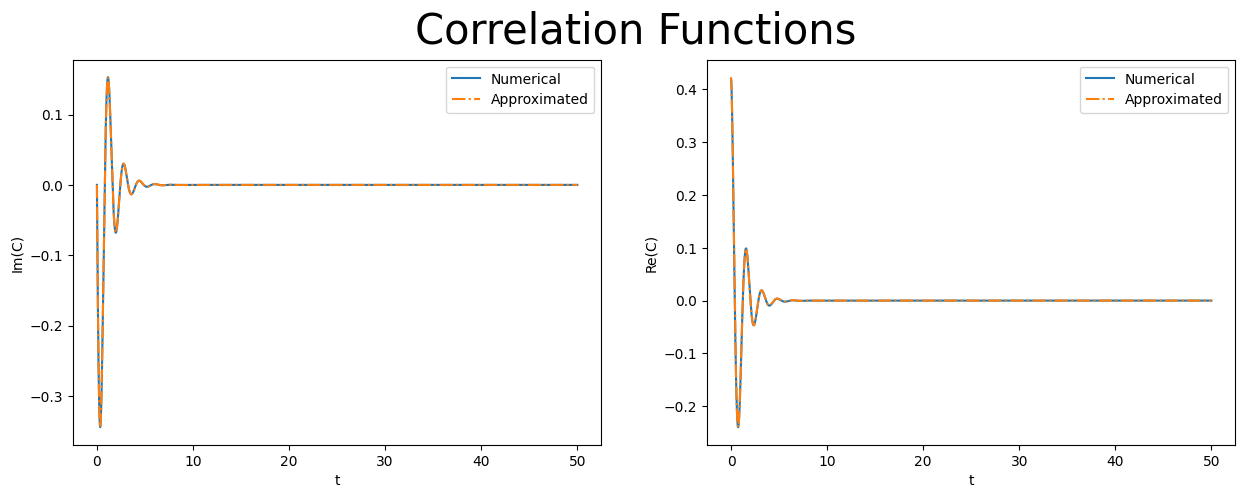

In [13]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [14]:
# ans = example.evolution(rho0, Ncutoff, times, options={
#                         "atol": 1e-14, "normalize_output": False, "store_states": True})
# ans = [i.ptrace(range(N))for i in ans.states]

In [15]:
from nmm import redfield

In [16]:
bath.bose=None
red = redfield.redfield(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-8,matsubara=False)

result_red = red.evolution(rho0)


Started interpolation


In [17]:
result_red=[Qobj(i) for i in result_red]
for i in result_red:
    i.dims=H.dims
result_red = rotation(result_red, H, times)

In [18]:
results=[result,result_cum,resultBR,resultBR2,result_red]

In [19]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Redfield"]
    style=["solid","solid","dashed","dashdot",'dashed','solid']
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

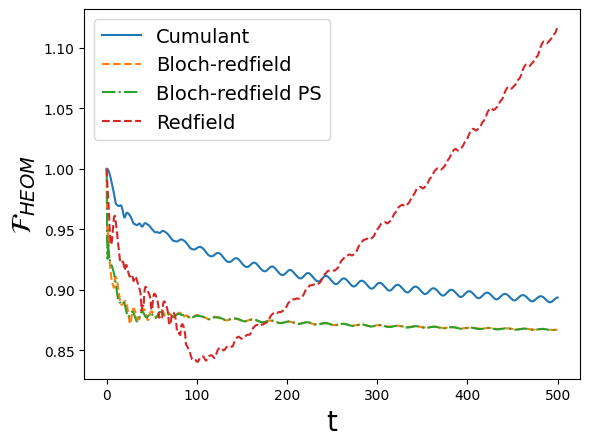

In [20]:
plot_fidelities(results,H,times)

In [21]:
result_red[498]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.19483396-1.35769389e-13j  0.02189807+9.18797169e-04j
  -0.00247211+3.00981306e-02j  0.01030054-4.21410674e-02j]
 [ 0.02189807-9.18797169e-04j  0.11543556-1.79647963e-14j
  -0.38462377+1.54079288e-02j  0.01300273-1.76759609e-02j]
 [-0.00247211-3.00981306e-02j -0.38462377-1.54079288e-02j
   1.12809498+1.98452366e-13j -0.0615489 -4.15630859e-02j]
 [ 0.01030054+4.21410674e-02j  0.01300273+1.76759609e-02j
  -0.0615489 +4.15630859e-02j -0.04869658-2.52436715e-14j]]

/home/gerardo/miniconda3/envs/spinchain/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gerardo/miniconda3/envs/spinchain/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


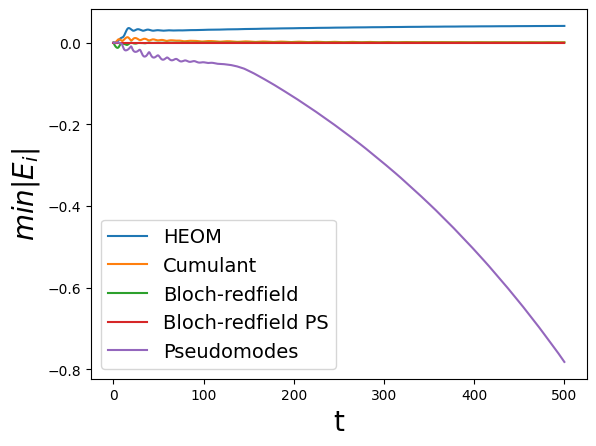

In [22]:
plot_positivity(results,H,times)

In [23]:
def plot_positivity(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([np.min(i.states[j].eigenenergies()) for j in range(len(times))])
        except:
            sdd=np.array([np.min(i[j].eigenenergies())  for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k])
   # plt.ylim(-1e-3,0.001)
    plt.legend(fontsize=14)
    plt.ylabel(r"$min |E_i|$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

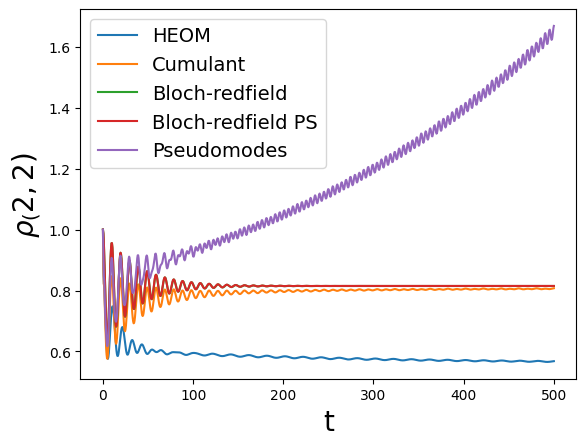

In [24]:
plot_populations(results,H,times,l=2,m=2)

In [25]:
from qutip import qsave

In [26]:
#qsave(results,f"N={N}_schwinger_{lam}_nocheating_seems_hard")